

## Applying Sentiment analysis to movie review using Kaggle labeled dataset.

https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

### Sentiment model classification based on labled Kaggle dataset  


## Part 2-Create, Test & Save Sentiment Model
__Summary__:  


Create a sentiment analysis algorithm using labeled kaggle movie reviews.  Part 1 cleaned and saved reviews to a database. This post adjusts the Kaggle dataset to comply with a binary classification, in which the target variable only has two classes to be predicted. For this post, the classes are either “negative” or “positive”. Labeled reviews are marked as either a __positive__(> 3) or __negative__(<3) movie review. The Kaggle dataset reviews are labeled as 0 - 4 (neg - pos) based on the training set.  
In short, the NLTK library is used to extract POS (parts-of-speech- adjectives) from reviews to use as __features__ for each movie review. These featuresets are then used to train the sentiment models.  The feature sets associated with the labeled reviews are measured against a bag-of-words to calculate the likelihood of the review being categorized as a positive or negative sentiment.  

Combining classifier algorithms is a common technique, done by creating a sort of voting system, where each algorithm gets one vote, and the classification that has the most votes is the chosen one.  In NLTK, classifiers are defined using classes that implement the ClassifyI interface. A processing interface for labeling tokens with a single category label (or "class"). Labels are typically strings or integers, but can be any immutable type. The set of labels that the classifier chooses from must be fixed and finite.




1.  Create two tables, one for negative reviews and one for positive reviews. 
2.  Use NLTK to tokenize phrases, create featuresets, and test Scikitlearn classificaion models.   
---



In [1]:
#!/usr/local/bin/python3.6
#import logging
import os
import pyodbc
import psycopg2
import psycopg2.extras
import numpy as np
import pandas as pd
import pandas.io.sql as psql
from sqlalchemy import create_engine

In [2]:
#postgres authentication
user = "alexp"
password = "secret"
host = "pg_db"
port = "5432"
database = "priv_workspace"

In [3]:
#view pg environment
try:
    connection = psycopg2.connect(user = user,
                                  password = password,
                                  host = host,
                                  port = port,
                                  database = database)
    cursor = connection.cursor()
    # Print PostgreSQL Connection properties
    print ( connection.get_dsn_parameters(),"\n")
    # Print PostgreSQL version
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record,"\n")
except (Exception, psycopg2.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

{'user': 'alexp', 'dbname': 'priv_workspace', 'host': 'pg_db', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '1', 'krbsrvname': 'postgres'} 

You are connected to -  ('PostgreSQL 10.5 (Debian 10.5-1.pgdg90+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 6.3.0-18+deb9u1) 6.3.0 20170516, 64-bit',) 

PostgreSQL connection is closed


#### 1.  Create two tables, one for negative reviews and one for positive reviews.

In [4]:
#create table of full sentences 
sql1 = '''
SELECT phrase
FROM "sent_train_tble"
where sentiment < 2
'''
sql2 = '''
SELECT phrase
FROM "sent_train_tble"
where sentiment > 3
'''

In [5]:
negativefilename = 'negative.txt'
positivefilename = 'positive.txt'

In [6]:
#SAVE TO QUERY TO TEXT FILES
from psycopg2 import Error
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT


try:
    connection = psycopg2.connect(user = user,
                                  password = password,
                                  host = host,
                                  port = port,
                                  database = database)
    cursor = connection.cursor()
    connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    engine_string = "postgresql://{}:{}@{}:{}/{}".format(user, password, host, port, database)
    engine = create_engine(engine_string)
    
    outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(sql1)
        
    with open(negativefilename, 'w') as f:
        cursor.copy_expert(outputquery, f)
    
    print('created file', negativefilename)
    
    outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(sql2)
        
    with open(positivefilename, 'w') as f:
        cursor.copy_expert(outputquery, f)
    
    print('created file', positivefilename)    


except (Exception, psycopg2.DatabaseError) as error :
    print ("Error while creating PostgreSQL table", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

created file negative.txt
created file positive.txt
PostgreSQL connection is closed


####  2.  Use NLTK to tokenize phrases, create featuresets, and test Scikitlearn classificaion models.
***details of function find_features(document)***   
creates an array of the top 5000 most frequent words that are in each of the notes already classified as pos or neg.  
each of the top 5k words in note is assigned a booleen values:   
({
'flat': False, 'horizontal': False, 'library': False...},'pos'), <br\>
({'flat': False, 'horizontal':  False, 'library': False...},'pos')...<br\>
]  

##### This process needs to be completed load each time new reviews that are categorized are to be used for a new recalibrated training set

Documents, all features frequencies and top 5000 features frequencies for training set are stored to pickle files for saving each classifier model and allow reduce the amount of time to process the saved sentiment model.

In [7]:
import nltk
import random
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
import string

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

from nltk.classify import ClassifierI
from statistics import mode

from nltk.tokenize import word_tokenize
from nltk import FreqDist

In [8]:
#creates documents list with class and all_words (using part of speech nltk for filtering only
# adjectives for a list to to use as features for creating classification
#filepath
negativefilename = 'negative.txt'
positivefilename = 'positive.txt'

#opens local files
short_pos = open(str(positivefilename), 'r', encoding="utf8").read()
short_neg = open(str(negativefilename), 'r', encoding="utf8").read()

#splits each line in each file, appends text 'pos' and 'neg' to line added to created documents list
documents = []
all_words = []

#  j is adjective, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J"]
# appending to docoments for training and test classificaton and creating all_words for all features to be tested
for p in short_pos.split('\n'):            #splits on new rows then loops by split
    documents.append( (p, "pos") )         #each split adds review and 'pos'
    words = word_tokenize(p)               #word tokenize each p
    exclude = set(string.punctuation)
    clean = ["''", '``']
    words = [w for w in words if w not in exclude and w.isalpha() and w not in clean]
    #words = [w for w in words if w not in stopwords]
    pos = nltk.pos_tag(words)              #uses function pos_tag for inner loop for words checking part of speech
    for w in pos:
        if w[1][0] in allowed_word_types:    #need better understanding of w[1][0]
            all_words.append(w[0].lower())

    
for p in short_neg.split('\n'):
    documents.append( (p, "neg") )
    words = word_tokenize(p)
    exclude = set(string.punctuation)
    clean = ["''", '``']
    words = [w for w in words if w not in exclude and w.isalpha() and w not in clean]
    #words = [w for w in words if w not in stopwords]
    pos = nltk.pos_tag(words)
    for w in pos:
        if w[1][0] in allowed_word_types:      #pos function tupple [1 is postive ??]
            all_words.append(w[0].lower())
            

#dictionary with key and value of most commom to least common words
all_words = nltk.FreqDist(all_words)             
# limit the use of the only the top 5000 words in the all_words key value dictionary  {key = word, value=frequency}
word_features = list(all_words.keys())[:5000]

In [9]:
#saving documents to save processing time, this will be refreshed when training model is updated with new history
save_documents = open("documents.pickle","wb")
pickle.dump(documents, save_documents)
save_documents.close()

save_all_words = open("all_words_features.pickle","wb")
pickle.dump(all_words, save_all_words)
save_all_words.close()


#save top 5k word features for training sets built below
save_word_features = open("Algo_word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()


print(word_features[:15])

['quiet', 'introspective', 'entertaining', 'independent', 'worth', 'epic', 'sincere', 'absolute', 'primary', 'memorable', 'best', 'lead', 'smart', 'provocative', 'impossible']


#### view of word features used after processing for:
parts of speech classification and cleaing text for non alpha words

[('more', 123), ('bad', 122), ('good', 121), ('funny', 91), ('little', 89), ('much', 89), ('best', 83), ('other', 70), ('many', 69), ('own', 68), ('most', 64), ('new', 54), ('first', 53), ('better', 52), ('great', 49)]


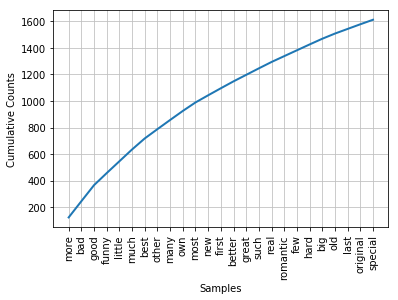

In [11]:
all_words_file = open("all_words_features.pickle","rb")
all_words_features = pickle.load(all_words_file)
print(all_words_features.most_common(15))
fdist1 = FreqDist(all_words_features)
fdist1.plot(25, cumulative=True)

all_words_file.close()

***this must be run when model is updated***, this will save the updated featuresets to a file using the updated notes stored above that were saved to new pickled documents and word features.  
the sentiment module is created by .....

In [12]:
def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)  #creates booleen value each word in document(note) as either true or false 

    return features 

In [13]:
#uses saved documents that are refreshed from source text files
documents_file = open("documents.pickle","rb")
documents = pickle.load(documents_file)
featuresets = [(find_features(note), category) for (note, category) in documents]

featuresets_f = open("features.pickle","wb")
pickle.dump(featuresets, featuresets_f)
featuresets_f.close()


print(len(featuresets))

4557


below uses saved pickled object file as 'featurset_f' created with find_features fuction as input to choice of classification alogorithims from randomized sample

In [14]:
#opening featuresets and creating training and test

featuresets_f = open("features.pickle","rb")
featuresets = pickle.load(featuresets_f)
random.shuffle(featuresets)
featuresets_f.close()

In [15]:
training_set = featuresets[:4400]
testing_set =  featuresets[4400:]

***uses the nltk and Sklearn py modules for classification and saves the classifier to pickle files***<br\>
training and test sets are defined in previous cell using the featuresets stored from current current documents file

In [17]:
# #### Combining Algorithms with NLTK and pickling to create a score for notes sentiment

class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):   #passes a list of classifiers
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf

In [18]:
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

save_classifier = open("pickled_algos_originalnaivebayes5k.pickle","wb")
pickle.dump(classifier, save_classifier)
save_classifier.close()
######

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

save_classifier = open("pickled_algos_MNB_classifier5k.pickle","wb")
pickle.dump(MNB_classifier, save_classifier)
save_classifier.close()
######

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

save_classifier = open("pickled_algos_BernoulliNB_classifier5k.pickle","wb")
pickle.dump(BernoulliNB_classifier, save_classifier)
save_classifier.close()
######

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

save_classifier = open("pickled_algos_LogisticRegression_classifier5k.pickle","wb")
pickle.dump(LogisticRegression_classifier, save_classifier)
save_classifier.close()
######


LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

save_classifier = open("pickled_algos_LinearSVC_classifier5k.pickle","wb")
pickle.dump(LinearSVC_classifier, save_classifier)
save_classifier.close()


##NuSVC_classifier = SklearnClassifier(NuSVC())
##NuSVC_classifier.train(training_set)
##print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)


SGDC_classifier = SklearnClassifier(SGDClassifier())
SGDC_classifier.train(training_set)
print("SGDClassifier accuracy percent:",nltk.classify.accuracy(SGDC_classifier, testing_set)*100)

save_classifier = open("pickled_algos_SGDC_classifier5k.pickle","wb")
pickle.dump(SGDC_classifier, save_classifier)
save_classifier.close()
######


voted_classifier = VoteClassifier(
                                  classifier,
                                  LinearSVC_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)

print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set))*100)


Original Naive Bayes Algo accuracy percent: 82.80254777070064
Most Informative Features
               wonderful = True              pos : neg    =     23.0 : 1.0
                touching = True              pos : neg    =     23.0 : 1.0
                gorgeous = True              pos : neg    =     17.9 : 1.0
              remarkable = True              pos : neg    =     16.2 : 1.0
                    warm = True              pos : neg    =     16.2 : 1.0
                     bad = True              neg : pos    =     16.2 : 1.0
              thoughtful = True              pos : neg    =     14.8 : 1.0
           extraordinary = True              pos : neg    =     12.8 : 1.0
               beautiful = True              pos : neg    =     12.1 : 1.0
                 delight = True              pos : neg    =     11.1 : 1.0
                   vivid = True              pos : neg    =     11.1 : 1.0
                terrific = True              pos : neg    =     10.7 : 1.0
            

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier accuracy percent: 82.80254777070064
voted_classifier accuracy percent: 81.52866242038218


### test the overall accuracy and better understand the accuarcy of positve verse negative predictions***

#### understand base predictions and the accruracy of positive verse negative sentiment predictions   
This can be accomplished quickly by quering the db for the positive and negative text files created earlier.


In [84]:
#SAVE TO QUERY TO TEXT FILES
from psycopg2 import Error
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT


try:
    connection = psycopg2.connect(user = user,
                                  password = password,
                                  host = host,
                                  port = port,
                                  database = database)
    cursor = connection.cursor()
    connection.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
    engine_string = "postgresql://{}:{}@{}:{}/{}".format(user, password, host, port, database)
    engine = create_engine(engine_string)
    
    negativeCount = "SELECT count(*) FROM sent_train_tble where sentiment < 2"
    cursor.execute(negativeCount)
    negativeCount = cursor.fetchall()[0][0]
    print('negativeCount=', negativeCount)
    
    postiveCount = "SELECT count(*) FROM sent_train_tble where sentiment > 3"
    cursor.execute(postiveCount)
    postiveCount = cursor.fetchall()[0][0]    
    print("base positve setiment= ", postiveCount/(negativeCount+postiveCount))
        
    print('postiveCount= ', negativeCount)    


except (Exception, psycopg2.DatabaseError) as error :
    print ("Error while creating PostgreSQL table", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

negativeCount= 3272
base positve setiment=  0.2813529540962003
postiveCount=  3272
PostgreSQL connection is closed


#### if one was to guess negative, they would be correct 72% of the time.  Using the algorithyms above, prediction accuracy is roughly 82%.  This is better than guessing.   Anything better than 72% accuracy for negative is better than guessing while accuracy in predicting a postive review needs to be better than 28%.

*** the prediction value is not as usefull for predicting positive movie ratings versus predicting negative ratings. that will be won considering 30% accuracy is low, while predicting deals that have negative sentiment with 85% accuracy is pretty good prediction)***<br \>
by not randomizing featuresets then testing 1st 100 which should be positive as documents were appended by pos then neg notes using saved classification models above

>1.) opening featuresets without shuffling  
>2.) creating training and test for postive docuents and to test accuracy of pos vs negative prediction in (similar to confusion matrix)  
>3.) negative accuracy

In [19]:
#######to look at document order to confirm pos and negative order ##############
# documents_f = open(str(filepath) + "documents.pickle","rb")
# documents = pickle.load(documents_f)
# documents_f.close()
# #print(documents[-100:]) #this shoud be a loop to look for 'neg' in documents

#1
featuresets_f = open("features.pickle","rb")
featuresets = pickle.load(featuresets_f)
#random.shuffle(featuresets)  this is to keep the order which is 1st hundred are positive vs last 100 negative
featuresets_f.close()
print(len(featuresets))

4557


In [20]:
#2 positive data example:      
training_set = featuresets[:4457]
testing_set =  featuresets[:100]
classifier = nltk.NaiveBayesClassifier.train(training_set)

classifier_f = open("pickled_algos_originalnaivebayes5k.pickle","rb")  
classifier = pickle.load(classifier_f)
classifier_f.close()

print("Original Naive Bayes Algo accuracy for predicting positive outcomes \n percent:", 
      (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)


MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)


BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, testing_set))*100)

##SVC_classifier = SklearnClassifier(SVC())
##SVC_classifier.train(training_set)
##print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, testing_set))*100)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)
print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)

voted_classifier = VoteClassifier(
                                  NuSVC_classifier,
                                  LinearSVC_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)

print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set))*100)

Original Naive Bayes Algo accuracy for predicting positive outcomes 
 percent: 69.0
Most Informative Features
               wonderful = True              pos : neg    =     23.0 : 1.0
                touching = True              pos : neg    =     23.0 : 1.0
                gorgeous = True              pos : neg    =     17.9 : 1.0
              remarkable = True              pos : neg    =     16.2 : 1.0
                    warm = True              pos : neg    =     16.2 : 1.0
                     bad = True              neg : pos    =     16.2 : 1.0
              thoughtful = True              pos : neg    =     14.8 : 1.0
           extraordinary = True              pos : neg    =     12.8 : 1.0
               beautiful = True              pos : neg    =     12.1 : 1.0
                 delight = True              pos : neg    =     11.1 : 1.0
                   vivid = True              pos : neg    =     11.1 : 1.0
                terrific = True              pos : neg    =     1

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier_classifier accuracy percent: 76.0
LinearSVC_classifier accuracy percent: 79.0
NuSVC_classifier accuracy percent: 46.0
voted_classifier accuracy percent: 64.0


In [21]:
#3 negative data example:      
training_set = featuresets[:4457]
testing_set =  featuresets[-100:]
classifier = nltk.NaiveBayesClassifier.train(training_set)

classifier_f = open("pickled_algos_originalnaivebayes5k.pickle","rb")  
classifier = pickle.load(classifier_f)
classifier_f.close()

print("Original Naive Bayes Algo accuracy for predicting negative outcomes \n percent:", 
      (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)


MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)


BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, testing_set))*100)

##SVC_classifier = SklearnClassifier(SVC())
##SVC_classifier.train(training_set)
##print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, testing_set))*100)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)
print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)

voted_classifier = VoteClassifier(
                                  NuSVC_classifier,
                                  LinearSVC_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)

print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set))*100)



Original Naive Bayes Algo accuracy for predicting negative outcomes 
 percent: 98.0
Most Informative Features
               wonderful = True              pos : neg    =     23.0 : 1.0
                touching = True              pos : neg    =     23.0 : 1.0
                gorgeous = True              pos : neg    =     17.9 : 1.0
              remarkable = True              pos : neg    =     16.2 : 1.0
                    warm = True              pos : neg    =     16.2 : 1.0
                     bad = True              neg : pos    =     16.2 : 1.0
              thoughtful = True              pos : neg    =     14.8 : 1.0
           extraordinary = True              pos : neg    =     12.8 : 1.0
               beautiful = True              pos : neg    =     12.1 : 1.0
                 delight = True              pos : neg    =     11.1 : 1.0
                   vivid = True              pos : neg    =     11.1 : 1.0
                terrific = True              pos : neg    =     1

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier_classifier accuracy percent: 94.0
LinearSVC_classifier accuracy percent: 90.0
NuSVC_classifier accuracy percent: 98.0
voted_classifier accuracy percent: 97.0


### Create Python Module that will be used on kaggle test reviews for sentiment analysis 

In [7]:
%%writefile sentiment_mod.py
#saved to file sentiment_mod.py
import nltk
import random
#from nltk.corpus import movie_reviews
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize


class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf


documents_f = open("documents.pickle", "rb")
documents = pickle.load(documents_f)
documents_f.close()


word_features5k_f = open("Algo_word_features5k.pickle", "rb")
word_features = pickle.load(word_features5k_f)
word_features5k_f.close()


def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features



featuresets_f = open("features.pickle", "rb")
featuresets = pickle.load(featuresets_f)
featuresets_f.close()

random.shuffle(featuresets)
#print(len(featuresets))

testing_set = featuresets[6900:]
training_set = featuresets[:6900]



open_file = open("pickled_algos_originalnaivebayes5k.pickle", "rb")
classifier = pickle.load(open_file)
open_file.close()


open_file = open("pickled_algos_MNB_classifier5k.pickle", "rb")
MNB_classifier = pickle.load(open_file)
open_file.close()



open_file = open("pickled_algos_BernoulliNB_classifier5k.pickle", "rb")
BernoulliNB_classifier = pickle.load(open_file)
open_file.close()


open_file = open("pickled_algos_LogisticRegression_classifier5k.pickle", "rb")
LogisticRegression_classifier = pickle.load(open_file)
open_file.close()


open_file = open("pickled_algos_LinearSVC_classifier5k.pickle", "rb")
LinearSVC_classifier = pickle.load(open_file)
open_file.close()


open_file = open("pickled_algos_SGDC_classifier5k.pickle", "rb")
SGDC_classifier = pickle.load(open_file)
open_file.close()




voted_classifier = VoteClassifier(
                                  classifier,
                                  LinearSVC_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)



def sentiment(text):
    feats = find_features(text)
    return voted_classifier.classify(feats),voted_classifier.confidence(feats)

Overwriting sentiment_mod.py


In [14]:
import sentiment_mod as s

#test the saved module against examples
print(s.sentiment('''An intermittently pleasing but mostly routine effort .'''))
print(s.sentiment('''Once you get bad its wonderful ... the movie wonderful a heady wonderful .'''))

('neg', 1.0)
('neg', 0.8)


In [10]:
print(s.sentiment('''The story and structure are well-honed .'''))

('neg', 1.0)
